In [1]:
from keras.datasets import mnist
import numpy as np
from matplotlib import pyplot as plt

Using TensorFlow backend.


In [2]:
import tensorflow as tf
from tensorflow.contrib import layers
from PIL import Image

In [3]:
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

In [4]:
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [5]:
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)

X_train = X_train.astype('float32')

# Scaling the range of the image to [-1, 1]
# Because we are using tanh as the activation function in the last layer of the generator
# and tanh restricts the weights in the range [-1, 1]
X_train = (X_train - 127.5) / 127.5

X_train.shape

(60000, 28, 28, 1)

In [6]:
def weight_variable(shape):
    """
    Create a weight variable with appropriate initialization
    :param name: weight name
    :param shape: weight shape
    :return: initialized weight variable
    """
    initer = tf.truncated_normal_initializer(stddev=0.01)
    return tf.get_variable('W', dtype=tf.float32, shape=shape, initializer=initer)

In [7]:
def bias_variable(shape):
    """
    Create a bias variable with appropriate initialization
    :param name: bias variable name
    :param shape: bias variable shape
    :return: initialized bias variable
    """
    initial = tf.constant(0., shape=shape, dtype=tf.float32)
    return tf.get_variable('b', dtype=tf.float32, initializer=initial)

In [8]:
def fc_layer(x, num_units, name, use_relu=True):
    """
    Create a fully-connected layer
    :param x: input from previous layer
    :param num_out: number of hidden units in the fully-connected layer
    :param name: layer name
    :param use_relu: boolean to add ReLU non-linearity (or not)
    :return: The output array
    """
    with tf.variable_scope(name):
        in_dim = x.get_shape()[1]
        W = weight_variable(shape=[in_dim, num_units])
        tf.summary.histogram('weight', W)
        b = bias_variable(shape=[num_units])
        tf.summary.histogram('bias', b)
        layer = tf.matmul(x, W)
        layer += b
        if use_relu:
            layer = tf.nn.relu(layer)
        return layer

### Using PRelu (parametarized leaky relu to correctly avoid dying Relu problem )  and Leaky Relu problem where negetive data only provide small amount of slope for learning parameter so that network itself familirize the required slope paramter for negative input value

In [9]:
def Prelu(inpt, name):
    """
    @inpt: input from previous layer
    @name: layer name
    """
    with tf.variable_scope(name):
        i = int(inpt.get_shape()[-1])
        alpha = tf.get_variable('alpha', shape=(i,))
        output = tf.nn.relu(inpt) + tf.multiply(alpha, -tf.nn.relu(-inpt))
    return output

In [10]:
def conv_layer(x, num_filters, filter_size, stride, name, use_relu=True):
    """
    Create a 2D convolution layer
    :param x: input from previous layer
    :param filter_size: size of each filter
    :param num_filters: number of filters (or output feature maps)
    :param stride: filter stride
    :param name: layer name
    :return: The output array
    """
    with tf.variable_scope(name):
        num_in_channel = x.get_shape().as_list()[-1]
        shape = [filter_size, filter_size, num_in_channel, num_filters]
        W = weight_variable(shape=shape)
        tf.summary.histogram('weight', W)
        b = bias_variable(shape=[num_filters])
        tf.summary.histogram('bias', b)
        layer = tf.nn.conv2d(x, W, strides=[1, stride, stride, 1], padding="SAME")
        layer += b
        if use_relu:
#         Using non - linearity RELU
            return tf.nn.relu(layer)
        return layer

In [11]:
def flatten_layer(layer):
    """
    Flattens the output of the convolutional layer to be fed into fully-connected layer
    :param layer: input array
    :return: flattened array
    """
    with tf.variable_scope('Flatten_layer'):
        layer_shape = layer.get_shape()
        num_features = layer_shape[1:4].num_elements()
        layer_flat = tf.reshape(layer, [-1, num_features])
    return layer_flat

In [12]:
def dropout(x, keep_prob,name):
    """Create a dropout layer."""
    return tf.nn.dropout(x, keep_prob,name=name)

In [13]:
lr = 0.001  # The optimization initial learning rate
epochs = 20  # Total number of training epochs
batch_size = 128  # Training batch size
display_freq = 50  # Frequency of displaying the training results

In [14]:
x = tf.placeholder(tf.float32, shape=[None, 28, 28, 1], name='X')
y = tf.placeholder(tf.float32, shape=[None, 1], name='Y')
noise = tf.placeholder(tf.float32,shape=[None, 100], name='Noise')
phase = tf.placeholder(tf.bool, name='phase')

In [15]:
# Generator network
g_net = fc_layer(noise, 1024, name='g_fc1',use_relu=False)
g_net = Prelu(g_net, name='g_prelu_1')

g_net = layers.batch_norm(g_net, is_training=phase)

g_net = fc_layer(noise,7 * 7 * 256, name='g_fc2', use_relu=False)
g_net = Prelu(g_net, name='g_prelu_2')
#     Post activation Batch Normalization
g_net = layers.batch_norm(g_net, is_training=phase)

g_net = tf.reshape(g_net, [-1, 7, 7, 256])
g_net = layers.conv2d_transpose(g_net, 64, [4, 4], stride=2)
g_net = layers.conv2d_transpose(g_net, 32, [4, 4], stride=2)
# Make sure that generator output is in the same range as `inputs`
# ie [-1, 1].
g_output = layers.conv2d(g_net, 1, 4, normalizer_fn=None, activation_fn=tf.tanh)

Instructions for updating:
Colocations handled automatically by placer.


In [16]:
# Discriminator network
d_net = conv_layer(x, 64, 5, stride = 2, name='d_conv_1',use_relu=False)
d_net = Prelu(d_net, name='d_prelu_1')

d_net = dropout(d_net, 0.3, name='drop_1')

d_net = conv_layer(d_net, 128, 5, stride = 2, name='d_conv_2',use_relu=False)
d_net = Prelu(d_net, name='d_prelu_2')

d_net = dropout(d_net, 0.3, name='drop_2')

d_net = flatten_layer(d_net)
d_net = fc_layer(d_net,1,name='output_discriminator',use_relu=False)
d_output= tf.nn.sigmoid(d_net)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [17]:
with tf.variable_scope('discriminator'):
    with tf.variable_scope('Train'):
        with tf.variable_scope('Loss'):
            d_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=y, logits=d_output), name='loss')
        tf.summary.scalar('loss', d_loss)
        with tf.variable_scope('Optimizer'):
            d_optimizer = tf.train.AdamOptimizer(learning_rate=0.0001, name='Adam-op').minimize(d_loss)
        with tf.variable_scope('Accuracy'):
            d_correct_prediction = tf.equal(tf.argmax(d_output, 1), tf.argmax(y, 1), name='correct_pred')
            d_accuracy = tf.reduce_mean(tf.cast(d_correct_prediction, tf.float32), name='accuracy')
        tf.summary.scalar('accuracy', d_accuracy)
        with tf.variable_scope('Prediction'):
#             d_cls_prediction = tf.argmax(d_output, axis=1, name='predictions')
            d_cls_prediction = d_output

In [18]:
with tf.variable_scope('generator'):
    with tf.variable_scope('Train'):
        with tf.variable_scope('Loss'):
            g_loss = d_loss
        tf.summary.scalar('loss', g_loss)
        with tf.variable_scope('Optimizer'):
            update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
            with tf.control_dependencies(update_ops):
                g_optimizer = tf.train.AdamOptimizer(learning_rate=0.0001, name='Adam-op').minimize(g_loss)
        with tf.variable_scope('Accuracy'):
            g_correct_prediction = tf.equal(tf.argmax(g_output, 1), tf.argmax(y, 1), name='correct_pred')
            g_accuracy = tf.reduce_mean(tf.cast(g_correct_prediction, tf.float32), name='accuracy')
        tf.summary.scalar('accuracy', g_accuracy)
        with tf.variable_scope('Prediction'):
#             g_cls_prediction = tf.argmax(g_output, axis=1, name='predictions')
            g_cls_prediction = g_output

In [19]:
# Initialize the variables
init = tf.global_variables_initializer()
# Merge all summaries
merged = tf.summary.merge_all()

In [20]:
saver = tf.train.Saver()

In [21]:
def randomize(x, y):
    """ Randomizes the order of data samples and their corresponding labels"""
    permutation = np.random.permutation(y.shape[0])
    shuffled_x = x[permutation, :, :, :]
    shuffled_y = y[permutation]
    return shuffled_x, shuffled_y

def get_next_batch(x, y, start, end):
    x_batch = x[start:end]
    y_batch = y[start:end]
    return x_batch, y_batch

In [22]:
sess = tf.InteractiveSession(config=tf.ConfigProto(log_device_placement=True))
sess.run(init)
global_step = 0
summary_writer = tf.summary.FileWriter('./logdir', sess.graph)
# Number of training iterations in each epoch

### Before training network visualizing the network output

In [23]:
def plot_output(preds):
    plt.figure(figsize=(10,10))
    for i in range(preds.shape[0]):
        plt.subplot(12, 12, i+1)
        plt.imshow(preds[i, :, :, 0], cmap='gray')
        plt.axis('off')
    
    # tight_layout minimizes the overlap between 2 sub-plots
    plt.tight_layout()

Training epoch: 1
training step 0 ..... 
 completed moving on to next traing step....
training step 1 ..... 
 completed moving on to next traing step....
training step 2 ..... 
 completed moving on to next traing step....
training step 3 ..... 
 completed moving on to next traing step....
training step 4 ..... 
 completed moving on to next traing step....
training step 5 ..... 
 completed moving on to next traing step....
training step 6 ..... 
 completed moving on to next traing step....
training step 7 ..... 
 completed moving on to next traing step....
training step 8 ..... 
 completed moving on to next traing step....
training step 9 ..... 
 completed moving on to next traing step....
training step 10 ..... 
 completed moving on to next traing step....
training step 11 ..... 
 completed moving on to next traing step....
training step 12 ..... 
 completed moving on to next traing step....
training step 13 ..... 
 completed moving on to next traing step....
training step 14 ..... 
 c

training step 119 ..... 
 completed moving on to next traing step....
training step 120 ..... 
 completed moving on to next traing step....
training step 121 ..... 
 completed moving on to next traing step....
training step 122 ..... 
 completed moving on to next traing step....
training step 123 ..... 
 completed moving on to next traing step....
training step 124 ..... 
 completed moving on to next traing step....
training step 125 ..... 
 completed moving on to next traing step....
training step 126 ..... 
 completed moving on to next traing step....
training step 127 ..... 
 completed moving on to next traing step....
training step 128 ..... 
 completed moving on to next traing step....
training step 129 ..... 
 completed moving on to next traing step....
training step 130 ..... 
 completed moving on to next traing step....
training step 131 ..... 
 completed moving on to next traing step....
training step 132 ..... 
 completed moving on to next traing step....
training step 133 ..

training step 237 ..... 
 completed moving on to next traing step....
training step 238 ..... 
 completed moving on to next traing step....
training step 239 ..... 
 completed moving on to next traing step....
training step 240 ..... 
 completed moving on to next traing step....
training step 241 ..... 
 completed moving on to next traing step....
training step 242 ..... 
 completed moving on to next traing step....
training step 243 ..... 
 completed moving on to next traing step....
training step 244 ..... 
 completed moving on to next traing step....
training step 245 ..... 
 completed moving on to next traing step....
training step 246 ..... 
 completed moving on to next traing step....
training step 247 ..... 
 completed moving on to next traing step....
training step 248 ..... 
 completed moving on to next traing step....
training step 249 ..... 
 completed moving on to next traing step....
training step 250 ..... 
 completed moving on to next traing step....
training step 251 ..

training step 355 ..... 
 completed moving on to next traing step....
training step 356 ..... 
 completed moving on to next traing step....
training step 357 ..... 
 completed moving on to next traing step....
training step 358 ..... 
 completed moving on to next traing step....
training step 359 ..... 
 completed moving on to next traing step....
training step 360 ..... 
 completed moving on to next traing step....
training step 361 ..... 
 completed moving on to next traing step....
training step 362 ..... 
 completed moving on to next traing step....
training step 363 ..... 
 completed moving on to next traing step....
training step 364 ..... 
 completed moving on to next traing step....
training step 365 ..... 
 completed moving on to next traing step....
training step 366 ..... 
 completed moving on to next traing step....
training step 367 ..... 
 completed moving on to next traing step....
training step 368 ..... 
 completed moving on to next traing step....
training step 369 ..

ValueError: num must be 1 <= num <= 100, not 101

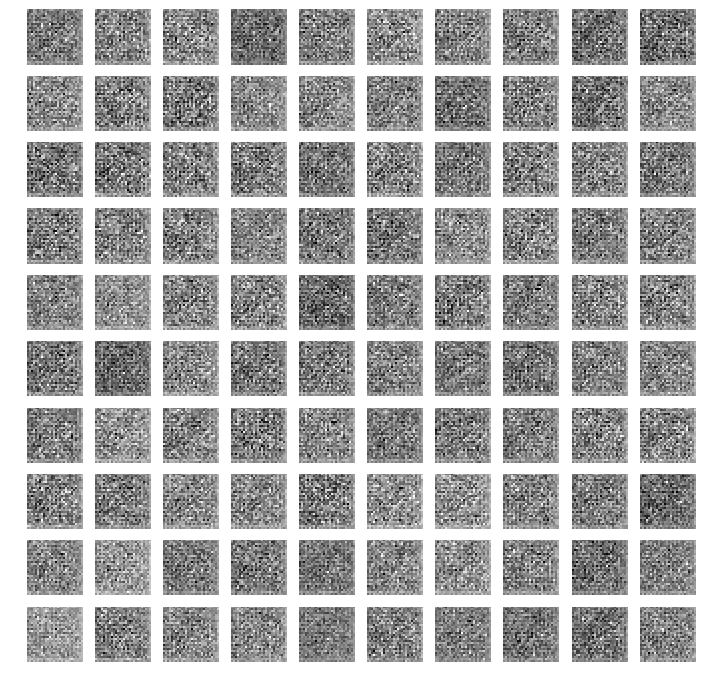

In [34]:
num_tr_iter = int(Y_train.shape[0]/ batch_size)
for epoch in range(epochs):
    print('Training epoch: {}'.format(epoch + 1))
    x_train, y_train = randomize(X_train, Y_train)
    for iteration in range(num_tr_iter):
        global_step += 1
        start = iteration * batch_size
        end = (iteration + 1) * batch_size
        image_batch ,_ = get_next_batch(x_train, y_train, start, end)

        # Input for the generator
        noise_input = np.random.rand(batch_size, 100)
        
        # these are the predicted images from the generator
        predictions = sess.run(g_cls_prediction,feed_dict={noise: noise_input,phase:0})
        
        # the discriminator takes in the real images and the generated images
        X = np.concatenate([predictions, image_batch])

        # labels for the discriminator
        y_discriminator = np.array([0]*batch_size + [1]*batch_size)
        y_discriminator = np.reshape(y_discriminator,(-1,1))
        
        # Let's train the discriminator
        sess.run(d_optimizer, feed_dict={x:X,y:y_discriminator})
        
        # Let's train the generator
        noise_input = np.random.rand(batch_size, 100)
        y_generator = np.reshape(np.array([1]*batch_size),(-1,1))
        sess.run(g_optimizer, feed_dict={noise:noise_input,x:generate,y:y_generator,phase:1})
        print(f"training step {iteration} ..... \n completed moving on to next traing step....")
        
#       lets look up new trained prediction of generator
    
    print(f"Visualizing the  Generator Prediction at epoch: {epoch}")
    plot_output(sess.run(g_cls_prediction,feed_dict={noise: np.random.rand(batch_size, 100),phase:0}))
    save_path = saver.save(sess, "model.ckpt"+"_"+str(epoch))
    print("Model saved in path: %s" % save_path+'_'+str(epoch))